## Q2 The Rope Trick (40 pts)
We're going to make a (discretized) rope stand up straight under it's own weight.

In [1]:
using Pkg;
const root = dirname(@__DIR__)
Pkg.activate(root);
Pkg.instantiate()

  Activating environment at `~/Projects/dynamics_simulation/hw3-brucekimrokcmu/Project.toml`


In [2]:
using LinearAlgebra, ForwardDiff, Plots, Test
const FD = ForwardDiff
using JLD2, FileIO
const jld2path = joinpath(root,"test");
include(joinpath(jld2path,"test_functions.jl"));

## 2A: Simulating an N link pendulum (20 pts)

In [3]:
#We're going to discretize the rope as a 2-dimensional N-link pendulum

#Parameters
const g = 9.81
const N = 3 #number of links

#All links are identical
const m = 1.0 #link mass
const ℓ = 1.0 #link length
const J = 1.0 #link inertia
const c = 0.01; #joint damping (Nm/rad/sec)

In [4]:
# Kinematics of an N-link planar pendulum
# all angles are defined in the +Z direction, joint angles are defined relative to the previous link, and 
# the global angles are all defined relative to the -Y axis. 

function kinematics(q)
    #Input: q is an N-dimensional vector of joint angles
    #Output: r is 3×N dimensional vector of global x,y,θ coordinates of each link
    
    r = zeros(eltype(q),3,N)
    θ = similar(q)
    θ[1] = q[1]
    r[:,1] = [[cos(θ[1]) -sin(θ[1]); sin(θ[1]) cos(θ[1])]*(0.5ℓ*[0;-1]);θ[1]]
    
    # TODO: fill in r
    for i = 2:N
        θ[i] = θ[i-1] + q[i]
        r[:,i] = [r[:,i-1][1:2] + 
        [cos(θ[i-1]) -sin(θ[i-1]); 
          sin(θ[i-1]) cos(θ[i-1])] * (0.5ℓ*[0;-1]) + 
            [cos(θ[i]) -sin(θ[i]); 
             sin(θ[i]) cos(θ[i])] * (0.5ℓ*[0;-1]); θ[i]]
    end

    #output is r stacked as a single vector
    return vec(r)

end

kinematics (generic function with 1 method)

In [5]:
@testset "kinematics" begin 
    
    q = [.1;.3;.4]
    k1 = [0.04991670832341408, -0.4975020826390129, 0.1, 0.2945425878011534, -1.4555346622794683, 0.4, 0.8479298044052401, -2.2644185139544937, 0.8]
    
    test_vec(kinematics(q),k1);
    
end

Test Summary: | Pass  Total
kinematics    |    9      9


Test.DefaultTestSet("kinematics", Any[Test.DefaultTestSet("element #1", Any[], 1, false, false), Test.DefaultTestSet("element #2", Any[], 1, false, false), Test.DefaultTestSet("element #3", Any[], 1, false, false), Test.DefaultTestSet("element #4", Any[], 1, false, false), Test.DefaultTestSet("element #5", Any[], 1, false, false), Test.DefaultTestSet("element #6", Any[], 1, false, false), Test.DefaultTestSet("element #7", Any[], 1, false, false), Test.DefaultTestSet("element #8", Any[], 1, false, false), Test.DefaultTestSet("element #9", Any[], 1, false, false)], 0, false, false)

In [6]:
function potential(q)
    #Input: q is an N-dimensional vector of joint angles 
    #Output: U is potential energy 
    
    # TODO: return the potential energy 
    # hint, you can use reshape(kinematics(q),3,N) to turn the kinematics back into a 3xN array 
    k = reshape(kinematics(q),3,N)

    M̄ = zeros(eltype(q), (N,N))
    for i = 1:N
        M̄[i,i] = m
    end
    
    h = zeros(eltype(q), (N,1))
    for i = 1:N
       h[i] = k[2,i] 
    end
    

    U = zero(eltype(q))
    U = sum(g*M̄*h)

    return U

end

potential (generic function with 1 method)

In [7]:
@testset "potential" begin 
    q = [.1;.3;.4]

    @test isapprox(potential(q), -41.37323608954388, atol=1e-7 )
end

Test Summary: | Pass  Total
potential     |    1      1


Test.DefaultTestSet("potential", Any[], 1, false, false)

In [8]:
function kinetic(q,q̇)
    #Input: q is an N-dimensional vector of joint angles, q̇ is an N-dimensional vector of joint velocities
    #Output: T is kinetic energy
    
    # TODO: output kinetic energy 
        
    dk = ForwardDiff.jacobian(dq->kinematics(dq),q) 

    M̄ = zeros((3N,3N))
    for i = 1:N
        M̄[3i-2,3i-2] = m
        M̄[3i-1,3i-1] = m
        M̄[3i,3i] = J
    end
    
    
    T = 0.5*q̇'dk'*M̄*dk*q̇
    
    return T
end

kinetic (generic function with 1 method)

In [9]:
@testset "kinetic energy" begin 
    q = [.1;-.3;.4]
    q̇ = [-.1;.21;.32]
    k1 = kinetic(q,q̇)
    @test isapprox(k1,0.13005245088411815, atol = 1e-7 )
end

Test Summary:  | Pass  Total
kinetic energy |    1      1


Test.DefaultTestSet("kinetic energy", Any[], 1, false, false)

In [10]:
function Lagrangian(q,q̇)
    ## TODO return the Lagrangian 
    Lag = zero(eltype([q;q̇]))
    Lag = kinetic(q,q̇) - potential(q)
    
    return Lag
end

Lagrangian (generic function with 1 method)

In [11]:
@testset "Lagrangian" begin 
    q = [.1;-.3;.4]
    q̇ = [-.1;.21;.32]
    L1 = Lagrangian(q,q̇)
    @test isapprox(L1,43.761435861572856, atol = 1e-7 )
end

Test Summary: | Pass  Total
Lagrangian    |    1      1


Test.DefaultTestSet("Lagrangian", Any[], 1, false, false)

In [12]:
#Lagrangian derivatives (no need to edit these)
function D1L(q,q̇)
    return ForwardDiff.gradient(dq->Lagrangian(dq,q̇),q)
end

function D2L(q,q̇)
    return ForwardDiff.gradient(dq̇->Lagrangian(q,dq̇),q̇)
end

function D2D2L(q,q̇)
    return ForwardDiff.jacobian(dq̇->D2L(q,dq̇),q̇)
end

function D1D2L(q,q̇)
    return ForwardDiff.jacobian(dq->D2L(dq,q̇),q)
end

D1D2L (generic function with 1 method)

In [13]:
function M(q)
    #Input: q is an N-dimensional vector of joint angles
    #Output: M is an N×N positive-definite mass matrix
        
    # TODO: output the mass matrix 
    _M = zeros(eltype(q),length(q),length(q))
    
    k = ForwardDiff.jacobian(x->kinematics(x),q)
    M̄ = zeros((3N,3N))
    for i = 1:N
        M̄[3i-2,3i-2] = m
        M̄[3i-1,3i-1] = m
        M̄[3i,3i] = J
    end
    
    _M = k'*M̄*k
    
    return _M
end

@testset "M" begin 
    q = [.1;-.3;.4]
    M1 = M(q)
    @test size(M1) == (N,N)
    test_vec(vec(M1), vec([11.53207462665773 6.351567810330307 2.2080325796404554; 6.351567810330307 4.421060994002885 1.7105304970014426; 2.2080325796404554 1.7105304970014426 1.25]))
end

Test Summary: | Pass  Total
M             |   10     10


Test.DefaultTestSet("M", Any[Test.DefaultTestSet("element #1", Any[], 1, false, false), Test.DefaultTestSet("element #2", Any[], 1, false, false), Test.DefaultTestSet("element #3", Any[], 1, false, false), Test.DefaultTestSet("element #4", Any[], 1, false, false), Test.DefaultTestSet("element #5", Any[], 1, false, false), Test.DefaultTestSet("element #6", Any[], 1, false, false), Test.DefaultTestSet("element #7", Any[], 1, false, false), Test.DefaultTestSet("element #8", Any[], 1, false, false), Test.DefaultTestSet("element #9", Any[], 1, false, false)], 1, false, false)

In [14]:
# q = [.1;-.3;.4]
# q̇ = [-.1;.21;.32]

# tmp = ForwardDiff.jacobian(x->M(x),q) vs M(x)*q̇


In [15]:
function C(q,q̇)
    #Input: q is an N-dimensional vector of joint angles
    #Output: C is an N-dimensional coriolis force vector
    
    # TODO: output coriolis term 
#     _C = zeros(eltype([q,q̇]),length(q))    
    _C = ForwardDiff.jacobian(x->M(x)*q̇,q)*q̇ - ForwardDiff.gradient(x->kinetic(x,q̇), q)
    
    return _C
end

@testset "C" begin 
    q = [.1;-.3;.4]
    q̇ = [-.1;.21;.32]
    C1 = C(q,q̇)

    @test size(C1) == (N,)
    test_vec(C1,[-0.041445288410249304, -0.03757938079215336, 0.0028551480542014767])
end

Test Summary: | Pass  Total
C             |    4      4


Test.DefaultTestSet("C", Any[Test.DefaultTestSet("element #1", Any[], 1, false, false), Test.DefaultTestSet("element #2", Any[], 1, false, false), Test.DefaultTestSet("element #3", Any[], 1, false, false)], 1, false, false)

In [16]:
function G(q)
    #Input: q is an N-dimensional vector of joint angles
    #Output: G is an N-dimensional gravitational force vector
    
    # TODO 
#     _G = zeros(eltype(q),length(q))
    
    _G = ForwardDiff.gradient(x->potential(x),q)
    
    return _G
end
@testset "G" begin 
    q = [.1;-.3;.4]
    G1 = G(q)
    @test size(G1) == (N,)
    test_vec(G1, [0.4994684081639105, -1.94894613509955, 0.9744730675497755])
end

Test Summary: | Pass  Total
G             |    4      4


Test.DefaultTestSet("G", Any[Test.DefaultTestSet("element #1", Any[], 1, false, false), Test.DefaultTestSet("element #2", Any[], 1, false, false), Test.DefaultTestSet("element #3", Any[], 1, false, false)], 1, false, false)

In [17]:
function manipulator_dynamics(x)
    #Input: x is an 2N-dimensional vector [q; q̇]
    #Output: ẋ is an 2N-dimensional vector [q̇; q̈]
    
    q = x[1:N]
    q̇ = x[N+1:end]
    
    # TODO: calculate and output the full state derivative 
    # hint: don't forget to add the joint damping force
    ẋ = zeros(eltype(x),length(x))
    
    #manipulator equations is just a restatement of euler lagrange equation
    
#     q̈ = M(q)\(-C(q,q̇) - c*q̇ -G(q))
    q̈ = D2D2L(q,q̇)\(D1L(q,q̇) - D1D2L(q,q̇)*q̇ - c*q̇)
    
    ẋ = [q̇;q̈]  
    
    return ẋ
end

@testset "manipulator dyamics" begin 
    q = [.1;-.3;.4]
    q̇ = [-.1;.21;.32]
    x = [q;q̇]
    ẋ1 = manipulator_dynamics(x)
    @test size(ẋ1) == (2*N,)
    test_vec(ẋ1,[-0.1, 0.21, 0.32, -1.7596230277740226, 4.415561990298298, -3.7185413505591836])
end

Test Summary:       | Pass  Total
manipulator dyamics |    7      7


Test.DefaultTestSet("manipulator dyamics", Any[Test.DefaultTestSet("element #1", Any[], 1, false, false), Test.DefaultTestSet("element #2", Any[], 1, false, false), Test.DefaultTestSet("element #3", Any[], 1, false, false), Test.DefaultTestSet("element #4", Any[], 1, false, false), Test.DefaultTestSet("element #5", Any[], 1, false, false), Test.DefaultTestSet("element #6", Any[], 1, false, false)], 1, false, false)

In [18]:
#Initial conditions corresponding to upright equilibrium
const q0 = [pi; zeros(N-1)]
const q̇0 = zeros(N)
const x0 = [q0; q̇0];

In [19]:
#Simulate near upward equilibrium using RK4 with 50Hz steps
const h = 0.02
const Tf = 30.0
const T = 0:h:Tf
const Nt = length(T)
xhist = zeros(2*N,Nt)
xhist[:,1] .= x0 + 1e-3*randn(2*N) #Add some noise to initial conditions

# TODO: simulate with rk4 (you don't need a function, you can just put the 5 lines inside the loop)
# hint: the ODE we are integrating is manipulator_dynamics(x)
for k = 1:(Nt-1)
    # add rk4 steps here 
    k1 = manipulator_dynamics(xhist[:,k])
    k2 = manipulator_dynamics(xhist[:,k] + h/2*k1)
    k3 = manipulator_dynamics(xhist[:,k] + h/2*k2)
    k4 = manipulator_dynamics(xhist[:,k] + h*k3)

    xhist[:,k+1] = xhist[:,k] + (h/6).*(k1 + 2k2 + 2k3 + k4)
    
end

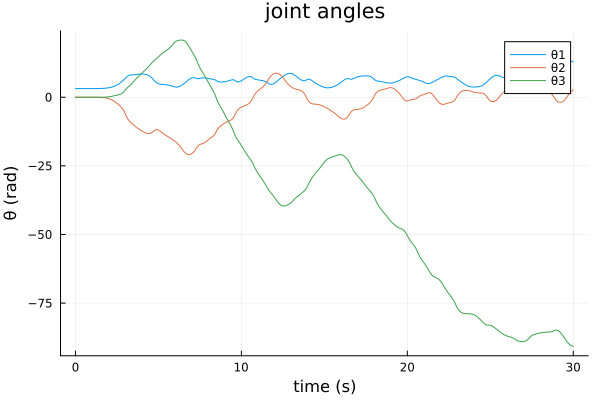

In [20]:
plot(T,xhist[1,:],label = "θ1")
plot!(T,xhist[2,:],label = "θ2")
plot!(T,xhist[3,:],label = "θ3")
xlabel!("time (s)")
ylabel!("θ (rad)")
title!("joint angles")

100% of animation loaded


┌ Info: Saved animation to /home/brucekimrok/Projects/dynamics_simulation/hw3-brucekimrokcmu/src/anim.gif
└ @ Plots /home/brucekimrok/.julia/packages/Plots/wutJB/src/animation.jl:149


Plots.AnimatedGif("/home/brucekimrok/Projects/dynamics_simulation/hw3-brucekimrokcmu/src/anim.gif")
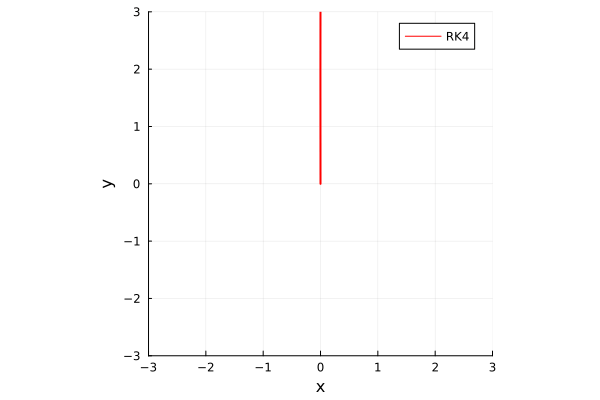

In [21]:
# animation (no need to modify this)
function endpoint_kinematics(x)
    q = [0;x[1:N]]
    xs = zeros(N+1)
    ys = zeros(N+1)
    for k = 2:N+1
        θ_n = sum(q[1:k])
        xs[k] = xs[k-1] + ℓ*sin(θ_n)
        ys[k] = ys[k-1] - ℓ*cos(θ_n)
    end
    return xs, ys
end

let
    fps = 15
    skip_factor = Int(round((1/h)/fps))
    anim = @animate for i = 1:skip_factor:length(T)
        IJulia.clear_output(true)
        println(string(Int(round(100*i/length(T))))*"% of animation loaded")
        t = T[i]
        x_rk4 = xhist[:,i]
        xs_rk4, ys_rk4 = endpoint_kinematics(x_rk4)
        plot(xs_rk4,ys_rk4,color = :red, xlim = [-N,N],ylim=[-N,N], aspect_ratio = :equal, label = "RK4",
              lw = 2, xlabel = "x", ylabel = "y")
        
    end
    gif(anim, "anim.gif", fps = fps) # run the cell again with this commented out to stop the animation
end

In [22]:
#Clearly the system is unstable
#Let's verify this by checking the eigenvalues of the A matrix at the equilibrium
let 
    # TODO calculate the dynamics jacobian (∂ẋ/∂x)
    _A = zeros(length(x0),length(x0))
    
    _A = ForwardDiff.jacobian(dx->manipulator_dynamics(dx), x0)
    
    eigvals(_A) #Should see some positive real eigenvalues
    
    @testset "A" begin 
        @test minimum(eigvals(_A)) < 0 ;
        @test maximum(eigvals(_A)) > 0 ;
    end
end

Test Summary: | Pass  Total
A             |    2      2


Test.DefaultTestSet("A", Any[], 2, false, false)

## 2B: N link pendulum with a moving base (20pts)

In [23]:
#Now we're going to drive the base of the pendulum up and down with a sinusoidal input
#We could do this by explicitly adding a DOF to the system and a corresponding force input, but we're going to try another way that doesn't involve adding states.
#Assume we have a mechanism that oscillates the base in the vertical direction with an amplitude ϵ and frequency f0

const ϵ = 0.25 #base drive amplitude (meters)
const f0 = 5.0 #base drive frequency (Hz)

function y_base(t)
    return ϵ*sin(2*pi*f0*t)
end

y_base (generic function with 1 method)

In [24]:
#Now we're going to write a new kinematics function that is time varying to account for the motion of the base

function kinematics(q,t)
    #Input: q is an N-dimensional vector of joint angles, t is time
    #Output: r is 3×N dimensional vector of global x,y,θ coordinates of each link
    
    # TODO: just like before, fill in r 
    r = zeros(eltype([q;t]),3,N)

    #Assume first link is pinned to the oscillating mechanism, which oscillates about the origin in the y direction
    
    θ = similar(q)
    θ[1] = q[1]
    r[:,1] = [[cos(θ[1]) -sin(θ[1]); sin(θ[1]) cos(θ[1])]*(0.5ℓ*[0;-1]);θ[1]]

    # TODO: fill in r
    for i = 2:N
        θ[i] = θ[i-1] + q[i]
        r[:,i] = [r[:,i-1][1:2] + 
        [cos(θ[i-1]) -sin(θ[i-1]); 
          sin(θ[i-1]) cos(θ[i-1])] * (0.5ℓ*[0;-1]) + 
            [cos(θ[i]) -sin(θ[i]); 
             sin(θ[i]) cos(θ[i])] * (0.5ℓ*[0;-1]); θ[i]]
    end
    
    for i = 1:N
        vec(r)[3i-1] += y_base(t)        
    end

    #output is r stacked as a single vector
    return vec(r)
end

@testset "kinematics 2" begin 
    q = [.1;-.3;.4]
    t = 4.67
    k1 = kinematics(q,t)
    test_vec(k1,[0.04991670832341408, -0.2952478340452739, 0.1, 0.0004987512492975604, -1.2827832056049076, -0.19999999999999998, 0.0004987512492975882, -2.262849783446149, 0.20000000000000004] )
end

Test Summary: | Pass  Total
kinematics 2  |    9      9


Test.DefaultTestSet("kinematics 2", Any[Test.DefaultTestSet("element #1", Any[], 1, false, false), Test.DefaultTestSet("element #2", Any[], 1, false, false), Test.DefaultTestSet("element #3", Any[], 1, false, false), Test.DefaultTestSet("element #4", Any[], 1, false, false), Test.DefaultTestSet("element #5", Any[], 1, false, false), Test.DefaultTestSet("element #6", Any[], 1, false, false), Test.DefaultTestSet("element #7", Any[], 1, false, false), Test.DefaultTestSet("element #8", Any[], 1, false, false), Test.DefaultTestSet("element #9", Any[], 1, false, false)], 0, false, false)

In [25]:
#Implement potential energy with this new time-varying kinematics

function potential(q,t)
    #Input: q is an N-dimensional vector of joint angles, t is time
    #Output: U is potential energy
    
    # TODO: output potential energy with the time-varying kinematics
    U = zero(eltype([q;t]))
    
    k = reshape(kinematics(q,t),3,N)

    M̄ = zeros(eltype([q;t]), (N,N))
    for i = 1:N
        M̄[i,i] = m
    end
    
    h = zeros(eltype([q;t]), (N,1))
    for i = 1:N
       h[i] = k[2,i] 
    end
    
    U = zero(eltype([q;t]))
    U = sum(g*M̄*h)

    
    return U
end

@testset "potential 2" begin 
    q = [.1;-.3;.4]
    t = 4.67
    p1 = potential(q,t)
    @test isapprox(p1, -37.679040874575, atol = 1e-8)
end

Test Summary: | Pass  Total
potential 2   |    1      1


Test.DefaultTestSet("potential 2", Any[], 1, false, false)

In [26]:
#Implement kinetic energy with this new time-varying kinematics

function kinetic(q,q̇,t)
    #Input: q is an N-dimensional vector of joint angles, q̇ is an N-dimensional vector of joint velocities, t is time
    #Output: T is kinetic energy
    
    # TODO: output kinetic energy (this time it's time varying due to the moving base)
    T = zero(eltype([q;q̇;t]))
    
    dk = ForwardDiff.jacobian(dq->kinematics(dq,t),q)
    #Kinematic Jacobian

    M̄ = zeros((3N,3N))
    for i = 1:N
        M̄[3i-2,3i-2] = m
        M̄[3i-1,3i-1] = m
        M̄[3i,3i] = J
    end

    v = dk*q̇
    for i = 1:N
       v[3i-1] += ForwardDiff.derivative(dt->y_base(dt),t) # <- ask TA about the difference between differentiating y_base(t) within kinematics and adding y_base_dot(t)  to velocities
    end
    
    T = 0.5*v'*M̄*v    
    
    return T
end

@testset "kinetic 2" begin 
    q = [.1;-.3;.4]
    q̇ = [.3;-.2;.1]
    t = 4.67
    k1 = kinetic(q,q̇,t)
    @test isapprox(k1, 31.932230230657254, atol = 1e-8)
end

Test Summary: | Pass  Total
kinetic 2     |    1      1


Test.DefaultTestSet("kinetic 2", Any[], 1, false, false)

In [27]:
#New time-varying Lagrangian

function Lagrangian(q,q̇,t)
    # TODO: output lagrangian 
    Lag = zero(eltype([q;q̇;t]))
    Lag = kinetic(q,q̇,t) - potential(q,t)
    return Lag
end

@testset "Lagrangian 2" begin 
    q = [.1;-.3;.4]
    q̇ = [.3;-.2;.1]
    t = 4.67
    L1 = Lagrangian(q,q̇,t);
    @test isapprox(L1, 69.61127110523225, atol = 1e-8)
end

Test Summary: | Pass  Total
Lagrangian 2  |    1      1


Test.DefaultTestSet("Lagrangian 2", Any[], 1, false, false)

In [28]:
#Overloading Lagrangian derivatives with new time-varying versions (no need to edit)

function D1L(q,q̇,t)
    return ForwardDiff.gradient(dq->Lagrangian(dq,q̇,t),q)
end

function D2L(q,q̇,t)
    return ForwardDiff.gradient(dq̇->Lagrangian(q,dq̇,t),q̇)
end

function D2D2L(q,q̇,t)
    return ForwardDiff.jacobian(dq̇->D2L(q,dq̇,t),q̇)
end

function D1D2L(q,q̇,t)
    return ForwardDiff.jacobian(dq->D2L(dq,q̇,t),q)
end

D1D2L (generic function with 2 methods)

In [29]:
function oscillating_dynamics(x,t)
    #Input: x is an 2N-dimensional vector [q; q̇]
    #Output: ẋ is an 2N-dimensional vector [q̇; q̈]
    
    q = x[1:N]
    q̇ = x[N+1:end]
    
    ẋ = zeros(eltype([x;t]),length(x))
    
    # TODO: return full state derivative ẋ = [q̇; q̈]
    
    #Hint: The Euler-Lagrange equation still holds when the Lagrangian is time varying,
    #You can either just apply the EL equation, or you can figure out how to modify the manipulator equation
    #to include a new term that accounts for the time-varying base motion
    
#     q̇_t = copy(q̇)
#     q̇_t[2] += ForwardDiff.derivative(dt->y_base(dt),t)  
    DtD2L = ForwardDiff.derivative(dt->D2L(q,q̇,dt),t)
    
    
    q̈ = D2D2L(q,q̇,t)\(D1L(q,q̇,t) - D1D2L(q,q̇,t)*q̇ - c*q̇ - DtD2L)
    
    ẋ = [q̇;q̈]  
    
    return ẋ
end

@testset "dynamics 2" begin 
    q = [.1;-.3;.4]
    q̇ = [.3;-.2;.1]
    x = [q;q̇]
    t = 4.67
    ẋ2 = oscillating_dynamics(x,t)
    test_vec(ẋ2, [0.3, -0.2, 0.1, 33.88762614801432, -84.7478561708084, 71.18862356229356])
end

Test Summary: | Pass  Total
dynamics 2    |    6      6


Test.DefaultTestSet("dynamics 2", Any[Test.DefaultTestSet("element #1", Any[], 1, false, false), Test.DefaultTestSet("element #2", Any[], 1, false, false), Test.DefaultTestSet("element #3", Any[], 1, false, false), Test.DefaultTestSet("element #4", Any[], 1, false, false), Test.DefaultTestSet("element #5", Any[], 1, false, false), Test.DefaultTestSet("element #6", Any[], 1, false, false)], 0, false, false)

In [30]:
function rk4step(xk,t)
    # TODO: rk4 step with dynamics function 'oscillating_dynamics(x,t)'
    
    k1 = oscillating_dynamics(xk, h)
    k2 = oscillating_dynamics((xk + h/2*k1),t)
    k3 = oscillating_dynamics((xk + h/2*k2),t)
    k4 = oscillating_dynamics((xk + h*k3),t)

    xn = xk + (h/6).*(k1 + 2k2 + 2k3 + k4)
    
    return xn
end

rk4step (generic function with 1 method)

In [31]:
#Simulate near upward equilibrium using RK4 with 50Hz steps
using Random
Random.seed!(1234)
xhist = zeros(2*N,Nt)
xhist[:,1] .= x0 + 1e-3*randn(2*N)

for k = 1:(Nt-1)
    xhist[:,k+1] .= rk4step(xhist[:,k], T[k])
end

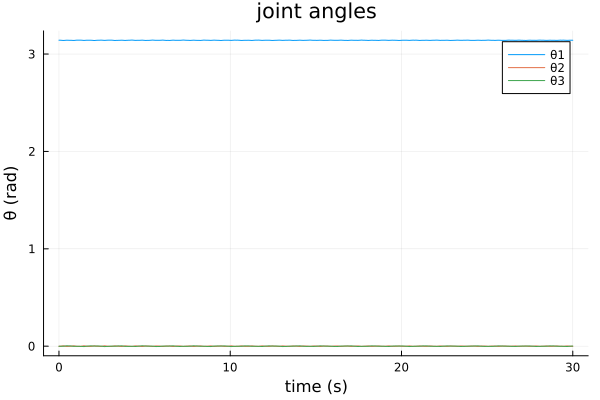

In [32]:
plot(T,xhist[1,:],label = "θ1")
plot!(T,xhist[2,:],label = "θ2")
plot!(T,xhist[3,:],label = "θ3")
xlabel!("time (s)")
ylabel!("θ (rad)")
title!("joint angles")

In [33]:
# make sure it's staying upright
@test maximum(abs.(π .- (xhist[1,:]))) < .2
@test maximum(abs.(xhist[2,:])) < .2
@test maximum(abs.(xhist[3,:])) < .2

Test Passed

100% of animation loaded


┌ Info: Saved animation to /home/brucekimrok/Projects/dynamics_simulation/hw3-brucekimrokcmu/src/anim.gif
└ @ Plots /home/brucekimrok/.julia/packages/Plots/wutJB/src/animation.jl:149


Plots.AnimatedGif("/home/brucekimrok/Projects/dynamics_simulation/hw3-brucekimrokcmu/src/anim.gif")
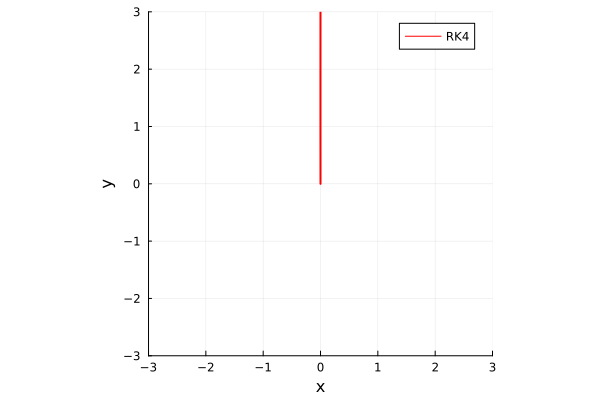

In [34]:
# animation (no need to modify this)
function endpoint_kinematics(x,t)
    q = [0;x[1:N]]
    xs = zeros(N+1)
    ys = zeros(N+1)
    for k = 2:N+1
        θ_n = sum(q[1:k])
        xs[k] = xs[k-1] + ℓ*sin(θ_n)
        ys[k] = ys[k-1] - ℓ*cos(θ_n)
    end
    ys = ys .+ y_base(t)
    return xs, ys
end

let
    fps = 15
    skip_factor = Int(round((1/h)/fps))
    anim = @animate for i = 1:skip_factor:length(T)
        IJulia.clear_output(true)
        println(string(Int(round(100*i/length(T))))*"% of animation loaded")
        t = T[i]
        x_rk4 = xhist[:,i]
        xs_rk4, ys_rk4 = endpoint_kinematics(x_rk4,t)
        plot(xs_rk4,ys_rk4,color = :red, xlim = [-N,N],ylim=[-N,N], aspect_ratio = :equal, label = "RK4",
              lw = 2, xlabel = "x", ylabel = "y")
        
    end
    gif(anim, "anim.gif", fps = fps) # run the cell again with the `let .. end` block commented out to stop the animation
end

In [35]:
#Clearly this system is now stable about the upward equilibrium
#Try playing around with ω0. You should find that there is a critical frequency above which it is stable (and below which it is not)
#Let's try proving stability analytically. To do this we're going to calculate something called the Monodromy matrix,
#which is the discrete-time Jacobian "A matrix" evaluated over exactly one period of oscillation of the system parameters

#Since we are driving the base at 5Hz and simulating at 50Hz, we need to compute A over 10 RK4 steps

function one_period_rk4(x0)
    x = deepcopy(x0)
    for k = 1:10
        x .= rk4step(x,h*(k-1))
    end
    return x
end
Amon = ForwardDiff.jacobian(dx->one_period_rk4(dx),x0)

6×6 Matrix{Float64}:
 -0.162527    0.866245   0.0569273   0.158808    0.0343798   0.00185899
  0.847873   -1.52993    0.0796219   0.0337741   0.104068    0.00321787
  0.259035    1.32376    0.113619    0.00684166  0.0514681   0.169878
 -9.70821    12.0149     0.352711    1.27884     0.0926701  -0.0228436
 11.9098    -29.255      0.924677    0.100479    1.09555     0.000359482
 -0.647652   17.0397    -5.3171     -0.244173    0.0565823   1.3397

In [36]:
#Now check eigenvalues of the Monodromy matrix. They should all be inside the unit circle, indicating stability over an oscillation period
@testset "Monodromy matrix" begin 
    @test maximum(abs.(eigvals(Amon)))<1.0
end

Test Summary:    | Pass  Total
Monodromy matrix |    1      1


Test.DefaultTestSet("Monodromy matrix", Any[], 1, false, false)